In [3]:
%load_ext autoreload
%autoreload 2

In [786]:
# Modifying the path so we can import from src directory.
import sys
import os
sys.path.append(os.path.abspath('..'))

from collections import Counter, defaultdict
from itertools import chain
import copy
import pickle
import random
import time

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from pyvis.network import Network

from src.example_graphs import simple_undirected_graph, simple_directed_graph
from src.UndirectedGraph import UndirectedGraph
from src.DirectedGraph import DirectedGraph
from src.DataLoader import DataLoader
from src.GraphCreator import GraphCreator, NetworkXGraphCreator

from src.io_helpers import pickle_obj, load_pickled_obj
from src.networkx_helpers import combine_graphs

In [5]:
ROOT_DIRECTORY = os.path.split(os.getcwd())[0]
DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data')
PICKLED_DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data_pickle')

In [6]:
G = nx.MultiDiGraph()
G.add_edge(1, 2, key=None, attr={
    'property1': 'something here',
    'property2': 2,
    'property3': [1, 2, 3, 'hello', lambda x: x**2],
    4: 'something here',
})
G.add_edge(1, 2, key=None, attr={
    'property2': 5
})

1

In [7]:
G[1]

AdjacencyView({2: {0: {'attr': {'property1': 'something here', 'property2': 2, 'property3': [1, 2, 3, 'hello', <function <lambda> at 0x111ce50e0>], 4: 'something here'}}, 1: {'attr': {'property2': 5}}}})

In [8]:
list(G.nodes_with_selfloops())

[]

In [9]:
for node in G:
    for node2 in G[node]:
        for edge in G[node][node2]:
            print(node, node2, G[node][node2][edge])

1 2 {'attr': {'property1': 'something here', 'property2': 2, 'property3': [1, 2, 3, 'hello', <function <lambda> at 0x111ce50e0>], 4: 'something here'}}
1 2 {'attr': {'property2': 5}}


In [10]:
# 1 is the node we're looking at
# 2 is the node that 1 points to
# 0 is the first edge
# 'attr' gets the attribute dict
attr_dict_1 = G[1][2][0]['attr']
attr_dict_1

{'property1': 'something here',
 'property2': 2,
 'property3': [1, 2, 3, 'hello', <function __main__.<lambda>(x)>],
 4: 'something here'}

In [11]:
attr_dict_1['property2']

2

In [12]:
# 1 is the node we're looking at
# 2 is the node that 1 points to
# 1 is the second edge
# 'attr' gets the attribute dict
attr_dict_2 = G[1][2][1]['attr']
attr_dict_2

{'property2': 5}

In [13]:
attr_dict_2['property2']

5

In [14]:
attr_dict_1['property2'] + attr_dict_2['property2']

7

In [15]:
def get_edge_attrs(graph, node1, node2):
    return dict(graph[node1][node2].items())

In [16]:
get_edge_attrs(G, 1, 2)

{0: {'attr': {'property1': 'something here',
   'property2': 2,
   'property3': [1, 2, 3, 'hello', <function __main__.<lambda>(x)>],
   4: 'something here'}},
 1: {'attr': {'property2': 5}}}

In [17]:
def aggregate_numeric_properties(graph, node1, node2, numeric_attrs, agg_func):
    attr_dict = get_edge_attrs(graph, node1, node2)
    aggregated_dict = {attr: [] for attr in numeric_attrs}
    for edge in attr_dict:
        for attr in numeric_attrs:
            aggregated_dict[attr].append(attr_dict[edge]['attr'][attr])
    
    for k in aggregated_dict:
        aggregated_dict[k] = agg_func(aggregated_dict[k])
    
    return aggregated_dict

In [18]:
aggregate_numeric_properties(G, 1, 2, ['property2'], np.median)

{'property2': 3.5}

In [19]:
def sum_numeric_properties(graph, node1, node2, numeric_attrs):
    """For now, this function just calls aggregate_numeric_properties.
    However, the original code is below if this turns out to be inefficient.
    
    attr_dict = get_edge_attrs(graph, node1, node2)
    summed_dict = {attr: 0 for attr in numeric_attrs}
    for edge in attr_dict:
        for attr in numeric_attrs:
            summed_dict[attr] += attr_dict[edge]['attr'][attr]
    
    return summed_dict
    """
    return aggregate_numeric_properties(graph, node1, node2, numeric_attrs, sum)

In [20]:
sum_numeric_properties(G, 1, 2, ['property2'])

{'property2': 7}

In [21]:
aggregate_numeric_properties(G, 1, 2, ['property2'], sum)

{'property2': 7}

In [22]:
def count_edges(graph, node1, node2):
    return len(graph[node1][node2])

In [23]:
count_edges(G, 1, 2)

2

# Loading Reddit Data as MultiDiGraph

## First, let's try loading a small subset and getting the edge counts.

In [24]:
body_filepath = os.path.join(DATA_DIRECTORY, 'soc-redditHyperlinks-body.tsv')
data_loader = DataLoader(filepath=body_filepath, num_lines=10000, cols_to_load=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])
node_edge_pairs = data_loader.load()

In [25]:
node_edge_pairs

array([['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'],
       ['leagueoflegends', 'teamredditteams'],
       ['theredlion', 'soccer'],
       ...,
       ['casualpokemontrades', 'pokemon'],
       ['advancedfitness', 'powerlifting'],
       ['baconreader', 'silverbugs']], dtype='<U1578')

In [40]:
graph_creator = NetworkXGraphCreator()
G = graph_creator.create_graph(node_edge_pairs, graph_type='multidigraph')

Data load into graph took 0.11858677864074707 seconds.


In [41]:
# Counting the number of out-edges to each subreddit from 'leagueoflegends'
[(edge_node, count_edges(G, 'leagueoflegends', edge_node)) for edge_node in G['leagueoflegends']]

[('teamredditteams', 1),
 ('leagueoflegendsmeta', 1),
 ('iama', 1),
 ('whowouldwin', 1),
 ('lolchampconcepts', 2),
 ('leagueofgiving', 1),
 ('beadsprites', 1),
 ('summonerschool', 5),
 ('loleventvods', 5),
 ('dogecoin', 1),
 ('loltwistedtreeline', 1),
 ('hearthstone', 1),
 ('wallpapers', 1),
 ('bestof', 1),
 ('askreddit', 1),
 ('starcraft', 1),
 ('photoshoprequest', 1),
 ('lolwallpaper', 1),
 ('lotro', 1)]

In [42]:
G['leagueoflegends']['summonerschool']

AtlasView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}})

In [43]:
# Creating a dictionary of out-edge counts for all nodes
d = {}
for node in G:
    d[node] = {}
    d[node]['edge_counts'] = [(edge_node, count_edges(G, node, edge_node)) for edge_node in G[node]]
    if d[node]['edge_counts']:
        max_edge_node = max(d[node]['edge_counts'], key=lambda x: x[1])
    else:
        max_edge_node = ('', 0)
    d[node]['max_edge'] = max_edge_node
    d[node]['max_edge_count'] = max_edge_node[1]
    d[node]['max_edge_node'] = max_edge_node[0]

In [44]:
# Creating a list of the the most-linked-to subreddits from a single subreddit.
# So for example, a value of (node, 10) below means that some specific subreddit linked to node 10 times.
# This might not actually be that helpful, but it's good to know that we can aggregate edge counts down.
sorted([d[x]['max_edge'] for x in d], key=lambda x: x[1], reverse=True)[:20]

[('iama', 30),
 ('soccer', 27),
 ('hockey', 20),
 ('nofapchristians', 19),
 ('nofapchristians', 19),
 ('argentina', 18),
 ('askreddit', 15),
 ('magictcg', 15),
 ('bitcoin', 15),
 ('hockey', 15),
 ('funny', 14),
 ('metalcore', 13),
 ('buildapcforme', 13),
 ('dogecoin', 13),
 ('atletico', 11),
 ('funny', 11),
 ('askwomen', 11),
 ('askreddit', 10),
 ('askreddit', 10),
 ('poketradereferences', 10)]

## Can we create a new graph where the edge weights are the counts of how many edges go from node to node?

In [45]:
G_weighted = nx.DiGraph()

In [46]:
weighted_edges = []
node = 'leagueoflegends'
for node in d:
    for edge_node, weight in d[node]['edge_counts']:
        edge_triplet = (node, edge_node, weight)
        weighted_edges.append(edge_triplet)

In [47]:
len(weighted_edges)

7312

In [48]:
G_weighted.add_weighted_edges_from(weighted_edges)

In [49]:
G_weighted['leagueoflegends']['summonerschool']

{'weight': 5}

In [50]:
# We should have the same number of nodes as before...
print(G.number_of_nodes())
print(G_weighted.number_of_nodes())

4076
4076


In [51]:
# ...but fewer edges, since we've compressed multiple edges down to a 'weight'.
print(G.number_of_edges())
print(G_weighted.number_of_edges())

9999
7312


In [52]:
# What happens to the nodes that have 0 weight going out of them?
d['bikela']

{'edge_counts': [],
 'max_edge': ('', 0),
 'max_edge_count': 0,
 'max_edge_node': ''}

In [53]:
G_weighted['bikela']

AtlasView({})

## Now, let's try loading the full dataset as a MultiDiGraph
I have a suspicion that how I'm calculating edge weights above is not going to be efficient enough for the full dataset...

In [54]:
G_body = load_pickled_obj(os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_multigraph_body.pickle'))
G_title = load_pickled_obj(os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_multigraph_title.pickle'))
G_combined = load_pickled_obj(os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_multigraph_combined.pickle'))

In [56]:
print(G_body.number_of_nodes())
print(G_title.number_of_nodes())
print(G_combined.number_of_nodes())

35776
54075
67180


In [57]:
print(G_body.number_of_edges())
print(G_title.number_of_edges())
print(G_combined.number_of_edges())

286561
571927
781866


**Not sure why we're getting a greater number of nodes than Stanford lists on their site.**

### Calculating edge weights for the full dataset

In [58]:
G_combined_weighted = nx.DiGraph()

In [59]:
# Creating a dictionary of out-edge counts for all nodes
d = {}
i = 1
for node in G_combined:
    if i % 1000 == 0:
        print(i)
    d[node] = {}
    d[node]['edge_counts'] = [(edge_node, count_edges(G_combined, node, edge_node)) for edge_node in G_combined[node]]
    if d[node]['edge_counts']:
        max_edge_node = max(d[node]['edge_counts'], key=lambda x: x[1])
    else:
        max_edge_node = ('', 0)
    d[node]['max_edge'] = max_edge_node
    d[node]['max_edge_count'] = max_edge_node[1]
    d[node]['max_edge_node'] = max_edge_node[0]
    i += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


In [60]:
weighted_edges = []
for node in d:
    for edge_node, weight in d[node]['edge_counts']:
        edge_triplet = (node, edge_node, weight)
        weighted_edges.append(edge_triplet)

In [61]:
G_weighted.add_weighted_edges_from(weighted_edges)

In [62]:
# This should be the same as G_combined, which it is.
G_weighted.number_of_nodes()

67180

In [63]:
# This should be less, which it is
G_weighted.number_of_edges()

339643

In [64]:
G_weighted['vegan']

AtlasView({'worldnews': {'weight': 26}, 'woahdude': {'weight': 2}, 'funny': {'weight': 16}, 'changemyview': {'weight': 15}, 'iama': {'weight': 36}, 'frugal': {'weight': 1}, 'vegetarian': {'weight': 6}, 'science': {'weight': 23}, 'todayilearned': {'weight': 32}, 'adviceanimals': {'weight': 11}, 'veganfitness': {'weight': 2}, 'calgary': {'weight': 1}, 'offmychest': {'weight': 1}, 'aww': {'weight': 13}, 'news': {'weight': 33}, 'wtf': {'weight': 15}, 'weddingplanning': {'weight': 1}, 'askreddit': {'weight': 57}, 'videos': {'weight': 21}, 'pics': {'weight': 10}, 'beautyboxes': {'weight': 1}, 'mildlyinteresting': {'weight': 3}, 'veganscience': {'weight': 1}, 'food': {'weight': 8}, 'tumblrinaction': {'weight': 7}, 'pets': {'weight': 1}, 'gifs': {'weight': 7}, 'holdmybeer': {'weight': 1}, 'bojackhorseman': {'weight': 1}, 'spain': {'weight': 1}, 'veganbookclub': {'weight': 1}, 'skincareaddiction': {'weight': 2}, 'vegrecipes': {'weight': 1}, 'subredditads': {'weight': 1}, 'getmotivated': {'weigh

In [65]:
sorted(nx.pagerank(G_weighted).items(), key=lambda x: x[1], reverse=True)

[('askreddit', 0.021360629665365234),
 ('iama', 0.01670523275980411),
 ('pics', 0.011220933863998236),
 ('funny', 0.010155471781302957),
 ('videos', 0.009193387374533107),
 ('todayilearned', 0.0069400271021285796),
 ('worldnews', 0.006106194033904912),
 ('gaming', 0.005768021604326954),
 ('news', 0.004797769055850077),
 ('science', 0.004451013992358437),
 ('gifs', 0.004359288201766917),
 ('leagueoflegends', 0.003991076773959163),
 ('wtf', 0.0038055564518849534),
 ('books', 0.003727554241457794),
 ('showerthoughts', 0.003534324014878249),
 ('politics', 0.0035251888246041743),
 ('adviceanimals', 0.0034740758363545022),
 ('writingprompts', 0.003362169301335374),
 ('bitcoin', 0.003336064178847318),
 ('the_donald', 0.003308418700855571),
 ('movies', 0.003254898240453419),
 ('aww', 0.003101836981762116),
 ('mildlyinteresting', 0.003074490332956596),
 ('music', 0.0030458699168507872),
 ('technology', 0.002930653857132003),
 ('pcmasterrace', 0.002910045191552715),
 ('conspiracy', 0.00286845236

# Save weighted graph as a pickle file

In [255]:
pickle_obj(G_weighted, os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_weighted_full.pickle'))

# Looking at Sharing Reciprocity
### First, let's look at a subset of our graph.

In [68]:
G_weighted_subset = G_weighted.edge_subgraph(G_weighted.edges('vegan'))

In [69]:
G_weighted_subset['vegan']['worldnews']

{'weight': 26}

In [70]:
def sharing_reciprocity(graph, n, m):
    try:
        n_to_m = graph[n][m]['weight']
    except:
        n_to_m = 0
    
    try:
        m_to_n = graph[m][n]['weight']
    except:
        m_to_n = 0
    
    if n_to_m + m_to_n == 0:
        return 0
    
    return {
        'reciprocity': n_to_m / (n_to_m + m_to_n),
        'summed weights': n_to_m + m_to_n,
        'n-to-m': n_to_m,
        'm_to_n': m_to_n
    }

In [71]:
sharing_reciprocity(G_weighted_subset, 'vegan', 'worldnews')

{'reciprocity': 1.0, 'summed weights': 26, 'n-to-m': 26, 'm_to_n': 0}

In [72]:
reciprocities = []
focus_node = 'vegan'
for neighbor_node in G_weighted_subset[focus_node]:
    reciprocities.append((neighbor_node, sharing_reciprocity(G_weighted, focus_node, neighbor_node)))

In [73]:
sorted(reciprocities, key=lambda x: x[1]['summed weights'], reverse=True)

[('askreddit',
  {'reciprocity': 1.0, 'summed weights': 57, 'n-to-m': 57, 'm_to_n': 0}),
 ('vegancirclejerk',
  {'reciprocity': 0.05263157894736842,
   'summed weights': 38,
   'n-to-m': 2,
   'm_to_n': 36}),
 ('iama',
  {'reciprocity': 1.0, 'summed weights': 36, 'n-to-m': 36, 'm_to_n': 0}),
 ('news',
  {'reciprocity': 1.0, 'summed weights': 33, 'n-to-m': 33, 'm_to_n': 0}),
 ('todayilearned',
  {'reciprocity': 1.0, 'summed weights': 32, 'n-to-m': 32, 'm_to_n': 0}),
 ('worldnews',
  {'reciprocity': 0.9629629629629629,
   'summed weights': 27,
   'n-to-m': 26,
   'm_to_n': 1}),
 ('science',
  {'reciprocity': 1.0, 'summed weights': 23, 'n-to-m': 23, 'm_to_n': 0}),
 ('subredditdrama',
  {'reciprocity': 0.08695652173913043,
   'summed weights': 23,
   'n-to-m': 2,
   'm_to_n': 21}),
 ('videos',
  {'reciprocity': 0.9545454545454546,
   'summed weights': 22,
   'n-to-m': 21,
   'm_to_n': 1}),
 ('philosophy',
  {'reciprocity': 1.0, 'summed weights': 20, 'n-to-m': 20, 'm_to_n': 0}),
 ('vegetari

In [74]:
sorted(reciprocities, key=lambda x: x[1]['reciprocity'], reverse=True)

[('woahdude',
  {'reciprocity': 1.0, 'summed weights': 2, 'n-to-m': 2, 'm_to_n': 0}),
 ('iama',
  {'reciprocity': 1.0, 'summed weights': 36, 'n-to-m': 36, 'm_to_n': 0}),
 ('frugal',
  {'reciprocity': 1.0, 'summed weights': 1, 'n-to-m': 1, 'm_to_n': 0}),
 ('science',
  {'reciprocity': 1.0, 'summed weights': 23, 'n-to-m': 23, 'm_to_n': 0}),
 ('todayilearned',
  {'reciprocity': 1.0, 'summed weights': 32, 'n-to-m': 32, 'm_to_n': 0}),
 ('adviceanimals',
  {'reciprocity': 1.0, 'summed weights': 11, 'n-to-m': 11, 'm_to_n': 0}),
 ('calgary',
  {'reciprocity': 1.0, 'summed weights': 1, 'n-to-m': 1, 'm_to_n': 0}),
 ('offmychest',
  {'reciprocity': 1.0, 'summed weights': 1, 'n-to-m': 1, 'm_to_n': 0}),
 ('news',
  {'reciprocity': 1.0, 'summed weights': 33, 'n-to-m': 33, 'm_to_n': 0}),
 ('wtf',
  {'reciprocity': 1.0, 'summed weights': 15, 'n-to-m': 15, 'm_to_n': 0}),
 ('weddingplanning',
  {'reciprocity': 1.0, 'summed weights': 1, 'n-to-m': 1, 'm_to_n': 0}),
 ('askreddit',
  {'reciprocity': 1.0, 's

## Now, let's calculate reciprocities for the whole graph

In [75]:
full_reciprocities = []
for focus_node in G_weighted:
    for neighbor_node in G_weighted[focus_node]:
        full_reciprocities.append({
            'focus_node': focus_node,
            'neighbor_node': neighbor_node,
            'reciprocity_dict': sharing_reciprocity(G_weighted, focus_node, neighbor_node)
        })

In [76]:
len(full_reciprocities)

339643

In [77]:
len(G_weighted)

67180

In [78]:
full_reciprocities[0]

{'focus_node': 'leagueoflegends',
 'neighbor_node': 'teamredditteams',
 'reciprocity_dict': {'reciprocity': 0.6,
  'summed weights': 65,
  'n-to-m': 39,
  'm_to_n': 26}}

In [79]:
full_reciprocities[0]['reciprocity_dict']['reciprocity']

0.6

## Looking at middling reciprocities

In [80]:
# Let's look where reciprocities are between 0.4 and 0.6
middling_reciprocities = [edge for edge in full_reciprocities if abs(edge['reciprocity_dict']['reciprocity']-0.5)<0.1]

In [81]:
len(middling_reciprocities)

28182

In [82]:
middling_reciprocities[:3]

[{'focus_node': 'leagueoflegends',
  'neighbor_node': 'teamredditteams',
  'reciprocity_dict': {'reciprocity': 0.6,
   'summed weights': 65,
   'n-to-m': 39,
   'm_to_n': 26}},
 {'focus_node': 'leagueoflegends',
  'neighbor_node': 'lolchampconcepts',
  'reciprocity_dict': {'reciprocity': 0.5384615384615384,
   'summed weights': 39,
   'n-to-m': 21,
   'm_to_n': 18}},
 {'focus_node': 'leagueoflegends',
  'neighbor_node': 'dogecoin',
  'reciprocity_dict': {'reciprocity': 0.5,
   'summed weights': 4,
   'n-to-m': 2,
   'm_to_n': 2}}]

## Now, let's look where the summed_weight is greater than some amount (people sharing a lot about the other)

In [83]:
middling_reciprocities_sum_gt_20 = [edge for edge in middling_reciprocities if edge['reciprocity_dict']['summed weights']>20]
len(middling_reciprocities_sum_gt_20)

896

In [84]:
middling_reciprocities_sum_gt_50 = [edge for edge in middling_reciprocities if edge['reciprocity_dict']['summed weights']>50]
len(middling_reciprocities_sum_gt_50)

234

In [85]:
middling_reciprocities_sum_gt_100 = [edge for edge in middling_reciprocities if edge['reciprocity_dict']['summed weights']>100]
len(middling_reciprocities_sum_gt_100)

68

Since each edge will be doubled here (since reciprocity is two-way), there are 34 subreddit relationships where people share a lot about each other and the sharing is about equal.

In [86]:
sorted(middling_reciprocities_sum_gt_100, key=lambda x: x['reciprocity_dict']['summed weights'], reverse=True)[:10]

[{'focus_node': 'buildapc',
  'neighbor_node': 'techsupport',
  'reciprocity_dict': {'reciprocity': 0.47863247863247865,
   'summed weights': 351,
   'n-to-m': 168,
   'm_to_n': 183}},
 {'focus_node': 'techsupport',
  'neighbor_node': 'buildapc',
  'reciprocity_dict': {'reciprocity': 0.5213675213675214,
   'summed weights': 351,
   'n-to-m': 183,
   'm_to_n': 168}},
 {'focus_node': 'destinythegame',
  'neighbor_node': 'crucibleplaybook',
  'reciprocity_dict': {'reciprocity': 0.46153846153846156,
   'summed weights': 286,
   'n-to-m': 132,
   'm_to_n': 154}},
 {'focus_node': 'crucibleplaybook',
  'neighbor_node': 'destinythegame',
  'reciprocity_dict': {'reciprocity': 0.5384615384615384,
   'summed weights': 286,
   'n-to-m': 154,
   'm_to_n': 132}},
 {'focus_node': 'subredditdrama',
  'neighbor_node': 'drama',
  'reciprocity_dict': {'reciprocity': 0.46,
   'summed weights': 250,
   'n-to-m': 115,
   'm_to_n': 135}},
 {'focus_node': 'drama',
  'neighbor_node': 'subredditdrama',
  'recip

## Now let's look at people who are ignored

In [87]:
# Ignored, but not quite totally ignored
ignored = [edge for edge in full_reciprocities if edge['reciprocity_dict']['reciprocity']>0.9 and edge['reciprocity_dict']['reciprocity']<1]

In [88]:
len(ignored)

1423

In [89]:
totally_ignored = [edge for edge in full_reciprocities if edge['reciprocity_dict']['reciprocity']==1]

In [90]:
len(totally_ignored)

279691

### Now, let's look at people who share a lot about the other and are still ignored

_**Actually not sure if it's "ignored" or if it should be called "gossipy".**_

In [91]:
# Ignored
print(len([edge for edge in ignored if edge['reciprocity_dict']['summed weights']>50]))
print(len([edge for edge in ignored if edge['reciprocity_dict']['summed weights']>100]))
print(len([edge for edge in ignored if edge['reciprocity_dict']['summed weights']>200]))

342
140
20


In [92]:
# Totally ignored
print(len([edge for edge in totally_ignored if edge['reciprocity_dict']['summed weights']>50]))
print(len([edge for edge in totally_ignored if edge['reciprocity_dict']['summed weights']>100]))
print(len([edge for edge in totally_ignored if edge['reciprocity_dict']['summed weights']>200]))

651
217
44


In [93]:
#Heavily Ignored / Big Media / Gossip / Paparazzi
[edge for edge in ignored if edge['reciprocity_dict']['summed weights']>200][:5]

[{'focus_node': 'bestof',
  'neighbor_node': 'todayilearned',
  'reciprocity_dict': {'reciprocity': 0.9957446808510638,
   'summed weights': 235,
   'n-to-m': 234,
   'm_to_n': 1}},
 {'focus_node': 'bestof',
  'neighbor_node': 'explainlikeimfive',
  'reciprocity_dict': {'reciprocity': 0.9952830188679245,
   'summed weights': 212,
   'n-to-m': 211,
   'm_to_n': 1}},
 {'focus_node': 'bestof',
  'neighbor_node': 'worldnews',
  'reciprocity_dict': {'reciprocity': 0.9953703703703703,
   'summed weights': 216,
   'n-to-m': 215,
   'm_to_n': 1}},
 {'focus_node': 'atletico',
  'neighbor_node': 'soccer',
  'reciprocity_dict': {'reciprocity': 0.9134199134199135,
   'summed weights': 231,
   'n-to-m': 211,
   'm_to_n': 20}},
 {'focus_node': 'goodshibe',
  'neighbor_node': 'dogecoin',
  'reciprocity_dict': {'reciprocity': 0.9739413680781759,
   'summed weights': 307,
   'n-to-m': 299,
   'm_to_n': 8}}]

In [94]:
#Totally Ignored / Big Media / Gossip / Paparazzi
[edge for edge in totally_ignored if edge['reciprocity_dict']['summed weights']>200][:5]

[{'focus_node': 'bestof',
  'neighbor_node': 'adviceanimals',
  'reciprocity_dict': {'reciprocity': 1.0,
   'summed weights': 217,
   'n-to-m': 217,
   'm_to_n': 0}},
 {'focus_node': 'bestof',
  'neighbor_node': 'funny',
  'reciprocity_dict': {'reciprocity': 1.0,
   'summed weights': 214,
   'n-to-m': 214,
   'm_to_n': 0}},
 {'focus_node': 'bestof',
  'neighbor_node': 'wtf',
  'reciprocity_dict': {'reciprocity': 1.0,
   'summed weights': 222,
   'n-to-m': 222,
   'm_to_n': 0}},
 {'focus_node': 'bestof',
  'neighbor_node': 'pics',
  'reciprocity_dict': {'reciprocity': 1.0,
   'summed weights': 222,
   'n-to-m': 222,
   'm_to_n': 0}},
 {'focus_node': 'bestof',
  'neighbor_node': 'politics',
  'reciprocity_dict': {'reciprocity': 1.0,
   'summed weights': 203,
   'n-to-m': 203,
   'm_to_n': 0}}]

This is beginning to look like it's all just "best_of", which makes sense, since this would aggregate things from all over but probably not be referenced back.

In [95]:
Counter([x['focus_node'] for x in [edge for edge in totally_ignored if edge['reciprocity_dict']['summed weights']>200]]).most_common()

[('circlebroke2', 7),
 ('bestof', 6),
 ('shitredditsays', 6),
 ('switcharoo', 4),
 ('shitpost', 3),
 ('shitstatistssay', 2),
 ('bestoftldr', 2),
 ('fitnesscirclejerk', 1),
 ('badphilosophy', 1),
 ('programmingcirclejerk', 1),
 ('edmprodcirclejerk', 1),
 ('mushroomkingdom', 1),
 ('bluejackets', 1),
 ('metacanada', 1),
 ('beercirclejerk', 1),
 ('trendingsubreddits', 1),
 ('bicyclingcirclejerk', 1),
 ('evenwithcontext', 1),
 ('titlegore', 1),
 ('nightlypick', 1),
 ('moronicmondayandroid', 1)]

In [96]:
Counter([x['focus_node'] for x in [edge for edge in ignored if edge['reciprocity_dict']['summed weights']>200]]).most_common()

[('bestof', 3),
 ('subredditdrama', 2),
 ('enoughlibertarianspam', 2),
 ('atletico', 1),
 ('goodshibe', 1),
 ('shitredditsays', 1),
 ('writingprompts', 1),
 ('badphilosophy', 1),
 ('japancirclejerk', 1),
 ('drugscirclejerk', 1),
 ('streetfighter', 1),
 ('shitpost', 1),
 ('runningcirclejerk', 1),
 ('babymetal', 1),
 ('mfacirclejerk', 1),
 ('baseballnightlypick', 1)]

# If you Went on a Random Walk...Where Would You End Up?
https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx (A resource that I haven't read yet. You can probably do this using matrix multiplication.)

## Let's start with a subset of the graph again

In [97]:
G_weighted_subset = G_weighted.edge_subgraph(G_weighted.edges('vegan'))

In [98]:
def random_node(graph):
    nodes = list(graph.nodes)
    
    return random.choice(nodes)

In [159]:
class RandomWalk:
    
    def __init__(self, graph, current_node=None, silent=True):
        self.steps_taken = 0
        self.blocked = False
        self.graph = graph
        if current_node:
            self.current_node = current_node
        else:
            self.current_node = random_node(self.graph)
        self.nodes_seen = defaultdict(int)
        self.nodes_seen[self.current_node] += 1
        self.silent = silent
    
    def walk(self):
        if self.blocked:
            if not self.silent:
                print("Can't take any more steps.")
        else:
            neighbor_nodes = []
            for neighbor in self.graph.adj[self.current_node]:
                neighbor_weight = self.graph.adj[self.current_node][neighbor]['weight']
                neighbor_nodes.extend([neighbor] * neighbor_weight)
            if neighbor_nodes:
                next_node = random.choice(neighbor_nodes)
                self.current_node = next_node
                self.nodes_seen[self.current_node] += 1
                self.steps_taken += 1
            else:
                self.blocked = True
                if not self.silent:
                    print("Can't take any more steps.")
    
    def delete_graph(self):
        """Method to delete the graph so we aren't using a bunch of memory."""
        self.graph = None

## Our RandomWalk walk was slowing down significantly, and I discovered that it was because we were storing a full copy of the graph inside of every instance of the RandomWalk class. With the graph size we were dealing with, this added up very quickly and probably locked down all the computer's memory.

In [133]:
# From https://stackoverflow.com/a/30316760/4807302
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [160]:
walk1 = RandomWalk(G_weighted)

In [161]:
for i in range(100):
    walk1.walk()
    if walk1.blocked:
        break

In [162]:
print(walk1.steps_taken)
print(Counter(walk1.nodes_seen).most_common())

3
[('gtaonlinehax', 1), ('gtamodding', 1), ('gta_5_hack_online', 1), ('gta5money', 1)]


In [163]:
print(getsize(walk1))

197055279


In [164]:
walk1.delete_graph()

In [165]:
getsize(walk1)

1160

In [166]:
walk2 = RandomWalk(G_weighted)
for i in range(100):
    walk2.walk()
    if walk2.blocked:
        break

In [167]:
print(walk2.steps_taken)
print(Counter(walk2.nodes_seen).most_common())

100
[('nba', 11), ('smashbros', 3), ('newzealand', 2), ('india', 2), ('leagueoflegends', 2), ('kappa', 2), ('streetfighter', 2), ('sf4', 2), ('diydrones', 2), ('multicopterbuilds', 2), ('writingprompts', 2), ('worldnews', 2), ('videos', 2), ('thunder', 2), ('torontoraptors', 2), ('futurology', 2), ('politics', 2), ('kiwiriders', 1), ('palmy', 1), ('dota2', 1), ('leagueofmeta', 1), ('ssbpm', 1), ('gifs', 1), ('aviation', 1), ('djimavic', 1), ('dji', 1), ('uavdrones', 1), ('rchobbyclassified', 1), ('multicopter', 1), ('worldbuilding', 1), ('penofigilix', 1), ('inthenews', 1), ('technology', 1), ('iama', 1), ('space', 1), ('arianespace', 1), ('isro', 1), ('cricket', 1), ('sports', 1), ('sixers', 1), ('orlandomagic', 1), ('memphisgrizzlies', 1), ('lakers', 1), ('nbaspurs', 1), ('rockets', 1), ('warriors', 1), ('chicagobulls', 1), ('suns', 1), ('utahjazz', 1), ('mkebucks', 1), ('timberwolves', 1), ('theredraft', 1), ('clevelandcavs', 1), ('resannouncements', 1), ('apple', 1), ('askreddit', 

In [168]:
getsize(walk2)

197059427

In [169]:
walk2.delete_graph()

In [170]:
getsize(walk2)

12338

In [171]:
random_walks = [walk1, walk2]

In [172]:
getsize(random_walks)

13486

## Go on the walks! You can change the i-range here (number of trials) and j-range (max length of the walk before we shut it down)

In [173]:
for i in range(10000):
    walk = RandomWalk(G_weighted)
    if i % 100 == 0:
        print(i)
    for j in range(1000):
        walk.walk()
        if walk.blocked:
            break
    walk.delete_graph()
    random_walks.append(copy.deepcopy(walk))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## Graphing the distribution of steps taken

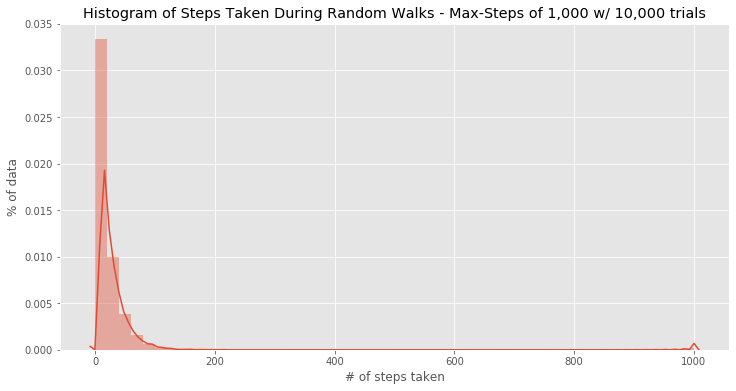

In [180]:
# This trial had max of 1000 steps per walk, and 10,000 trials.
step_counts = [walk.steps_taken for walk in random_walks]
fig = plt.figure(figsize=(12, 6))
ax = sns.distplot(step_counts)
_ = ax.set_title("Histogram of Steps Taken During Random Walks - Max-Steps of 1,000 w/ 10,000 trials")
_ = ax.set_ylabel("% of data")
_ = ax.set_xlabel("# of steps taken")

In [176]:
# These are the step counts from a previous trial.
# Max of 100 steps per walk, with 1000 trials.
step_counts_100_1000 = [17, 29, 1, 6, 8, 15, 14, 6, 0, 55, 4, 18, 9, 77, 33, 27, 0, 19, 41, 31, 6, 23, 25, 14, 2, 0, 34, 22, 11, 24, 21, 0, 94, 25, 28, 22, 11, 61, 0, 44, 0, 11, 40, 9, 20, 1, 43, 18, 6, 35, 0, 39, 1, 40, 16, 4, 5, 28, 14, 100, 17, 2, 5, 12, 15, 37, 34, 12, 23, 31, 0, 0, 61, 34, 21, 0, 18, 17, 4, 41, 25, 0, 48, 33, 0, 28, 9, 3, 5, 2, 0, 12, 47, 33, 41, 21, 20, 0, 15, 0, 2, 2, 5, 2, 41, 7, 20, 44, 10, 10, 35, 16, 42, 17, 1, 19, 0, 3, 54, 0, 2, 22, 9, 0, 24, 10, 40, 13, 40, 17, 24, 29, 0, 0, 27, 21, 16, 7, 7, 1, 20, 0, 1, 3, 0, 42, 16, 1, 43, 12, 2, 0, 10, 27, 0, 2, 0, 1, 65, 0, 3, 6, 1, 3, 19, 19, 12, 3, 3, 8, 7, 4, 7, 24, 1, 40, 0, 3, 6, 1, 26, 2, 56, 8, 5, 15, 100, 16, 33, 10, 11, 34, 3, 2, 1, 19, 22, 0, 2, 37, 1, 0, 21, 12, 0, 1, 15, 0, 0, 0, 0, 53, 13, 100, 9, 13, 40, 46, 17, 13, 2, 29, 16, 4, 1, 22, 26, 6, 26, 13, 3, 2, 41, 0, 27, 4, 16, 0, 33, 11, 26, 40, 43, 6, 42, 2, 2, 19, 8, 11, 14, 0, 0, 0, 11, 11, 0, 13, 22, 0, 12, 10, 7, 1, 18, 0, 2, 1, 7, 22, 2, 61, 39, 6, 45, 5, 5, 0, 7, 9, 23, 9, 4, 4, 25, 69, 0, 1, 14, 4, 5, 4, 4, 0, 22, 13, 0, 45, 9, 22, 1, 13, 68, 1, 6, 20, 0, 12, 24, 0, 30, 2, 18, 1, 7, 57, 0, 10, 15, 0, 7, 27, 8, 0, 20, 5, 5, 6, 10, 21, 16, 13, 12, 21, 1, 0, 2, 6, 25, 10, 8, 19, 0, 83, 28, 13, 5, 0, 3, 0, 40, 27, 63, 1, 11, 8, 22, 23, 1, 4, 2, 0, 0, 19, 1, 3, 24, 19, 0, 10, 9, 10, 5, 3, 18, 16, 1, 0, 22, 0, 74, 8, 21, 45, 40, 0, 55, 16, 28, 6, 62, 10, 12, 9, 4, 6, 6, 0, 15, 15, 0, 39, 1, 100, 43, 10, 36, 0, 18, 12, 3, 27, 57, 3, 0, 4, 2, 28, 24, 49, 2, 0, 15, 19, 34, 7, 0, 10, 40, 8, 20, 1, 19, 19, 17, 0, 57, 8, 19, 22, 30, 0, 10, 2, 2, 7, 5, 26, 6, 58, 23, 3, 16, 0, 3, 46, 3, 40, 3, 6, 31, 33, 52, 4, 5, 13, 0, 20, 5, 13, 22, 23, 0, 46, 73, 28, 1, 53, 10, 11, 10, 12, 13, 100, 21, 61, 0, 0, 0, 0, 8, 24, 1, 15, 16, 22, 6, 14, 8, 6, 3, 44, 15, 7, 25, 0, 9, 5, 0, 7, 15, 3, 22, 6, 16, 36, 6, 26, 12, 55, 0, 29, 5, 23, 2, 4, 8, 51, 84, 31, 1, 21, 17, 60, 52, 46, 5, 10, 0, 62, 24, 38, 13, 100, 4, 53, 16, 33, 9, 10, 29, 0, 3, 24, 64, 10, 4, 18, 6, 0, 11, 0, 46, 4, 36, 0, 3, 2, 6, 17, 3, 0, 23, 5, 3, 0, 25, 61, 9, 19, 8, 1, 17, 24, 1, 0, 10, 0, 0, 30, 45, 12, 2, 38, 15, 0, 0, 18, 46, 0, 0, 27, 32, 35, 9, 0, 11, 46, 6, 79, 5, 3, 59, 17, 73, 19, 2, 25, 13, 47, 4, 21, 20, 0, 14, 4, 100, 75, 0, 0, 63, 89, 25, 12, 15, 22, 15, 2, 14, 0, 55, 40, 42, 1, 64, 3, 0, 13, 38, 5, 0, 4, 0, 1, 0, 3, 3, 0, 10, 0, 22, 39, 7, 9, 6, 79, 7, 16, 9, 0, 7, 54, 0, 6, 3, 15, 17, 37, 10, 1, 12, 45, 100, 0, 34, 6, 7, 13, 28, 0, 19, 65, 59, 0, 2, 28, 35, 18, 45, 26, 2, 1, 2, 15, 7, 6, 10, 3, 17, 0, 45, 0, 16, 1, 21, 49, 77, 13, 27, 25, 11, 0, 42, 0, 9, 0, 1, 0, 60, 4, 61, 19, 17, 6, 9, 23, 5, 0, 2, 100, 29, 5, 0, 2, 13, 14, 31, 44, 12, 24, 12, 66, 51, 10, 68, 7, 2, 1, 9, 9, 55, 9, 17, 9, 0, 7, 3, 15, 13, 5, 12, 0, 0, 12, 0, 26, 2, 2, 0, 0, 21, 4, 0, 12, 97, 5, 58, 0, 1, 37, 21, 39, 28, 43, 42, 13, 0, 5, 6, 63, 0, 26, 0, 7, 10, 0, 17, 23, 13, 1, 19, 0, 23, 22, 2, 2, 3, 11, 13, 8, 33, 38, 1, 22, 12, 42, 0, 11, 0, 0, 7, 0, 12, 1, 0, 1, 10, 84, 43, 12, 9, 14, 95, 14, 30, 4, 43, 3, 24, 16, 15, 0, 7, 6, 10, 25, 2, 71, 6, 1, 13, 59, 7, 50, 51, 32, 0, 0, 17, 1, 0, 1, 30, 3, 1, 34, 8, 24, 31, 46, 0, 23, 33, 1, 1, 3, 52, 9, 2, 43, 21, 32, 4, 51, 2, 22, 53, 11, 18, 59, 48, 24, 10, 2, 22, 23, 8, 23, 7, 55, 0, 4, 36, 16, 11, 29, 0, 12, 41, 14, 34, 48, 5, 63, 27, 0, 2, 16, 0, 100, 1, 1, 11, 0, 0, 26, 57, 0, 6, 68, 0, 21, 0, 0, 20, 89, 4, 5, 44, 24, 4, 3, 4, 0, 6, 13, 100, 0, 0, 8, 9, 0, 45, 2, 19, 2, 41, 95, 17, 81, 13, 0, 18, 29, 12, 3, 13, 72, 0, 8, 13, 3, 1, 56, 87, 12, 37, 4, 15, 44, 28, 0, 14, 0, 19, 1, 18, 29, 0, 29, 40, 8]

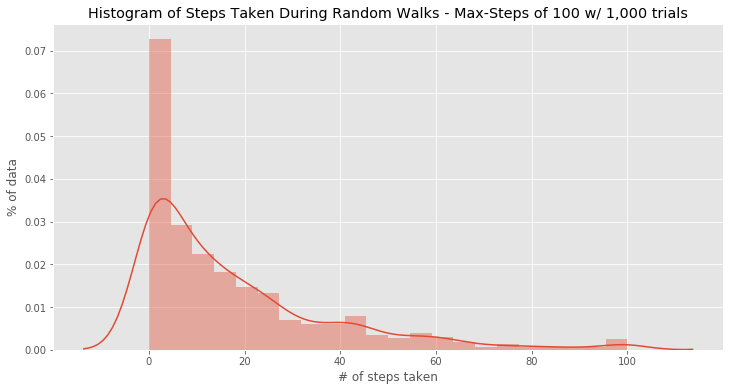

In [181]:
fig = plt.figure(figsize=(12, 6))
ax = sns.distplot(step_counts_100_1000)
_ = ax.set_title("Histogram of Steps Taken During Random Walks - Max-Steps of 100 w/ 1,000 trials")
_ = ax.set_ylabel("% of data")
_ = ax.set_xlabel("# of steps taken")

## What were the most common nodes seen?

In [186]:
for k, v in random_walks[0].nodes_seen.items():
    print(k, v)

gtaonlinehax 1
gtamodding 1
gta_5_hack_online 1
gta5money 1


In [187]:
all_nodes_seen = defaultdict(int)
for walk in random_walks:
    for node, seen_count in walk.nodes_seen.items():
        all_nodes_seen[node] += seen_count

In [188]:
len(all_nodes_seen)

23120

In [189]:
all_nodes_seen_counter = Counter(all_nodes_seen)

### Most common nodes seen on walks...

In [216]:
all_nodes_seen_counter.most_common()[:50]

[('askreddit', 4663),
 ('iama', 3903),
 ('pics', 2538),
 ('funny', 2303),
 ('videos', 2186),
 ('emeraldcoastbeer', 1976),
 ('pensacolabeer', 1975),
 ('todayilearned', 1656),
 ('worldnews', 1524),
 ('mpos', 1497),
 ('modelwestdistrict', 1496),
 ('judgedvideogames', 1495),
 ('allgamersunited', 1495),
 ('bloomingtonnormal', 1490),
 ('blono', 1489),
 ('gaming', 1316),
 ('science', 1173),
 ('news', 1145),
 ('hazardops', 1002),
 ('zmr', 1000),
 ('girlsinyogapants', 999),
 ('yogapants', 998),
 ('infinite_air', 996),
 ('infiniteair', 996),
 ('beachboys', 992),
 ('thebeachboys', 990),
 ('gifs', 982),
 ('2k14oa', 982),
 ('online2k14', 981),
 ('books', 975),
 ('mhoctoryconference', 969),
 ('mchristianinstitute', 969),
 ('wtf', 903),
 ('politics', 827),
 ('leagueoflegends', 822),
 ('adviceanimals', 820),
 ('movies', 814),
 ('showerthoughts', 797),
 ('music', 753),
 ('the_donald', 710),
 ('technology', 707),
 ('aww', 698),
 ('mildlyinteresting', 689),
 ('explainlikeimfive', 665),
 ('pcmasterrace', 

### In contrast, the most common nodes in the dataset by degree...

In [195]:
Counter(dict(G_combined.degree)).most_common()[:50]

[('subredditdrama', 26625),
 ('askreddit', 25633),
 ('bestof', 22489),
 ('iama', 12808),
 ('pics', 11981),
 ('todayilearned', 11586),
 ('funny', 11142),
 ('videos', 9557),
 ('titlegore', 9534),
 ('worldnews', 9201),
 ('shitredditsays', 8250),
 ('news', 7473),
 ('gaming', 7403),
 ('shitpost', 6875),
 ('drama', 6638),
 ('writingprompts', 6416),
 ('the_donald', 6338),
 ('circlebroke2', 6302),
 ('conspiracy', 6296),
 ('politics', 6039),
 ('switcharoo', 6002),
 ('shitamericanssay', 5852),
 ('wtf', 5499),
 ('adviceanimals', 5244),
 ('bitcoin', 5178),
 ('gifs', 5057),
 ('leagueoflegends', 4948),
 ('explainlikeimfive', 4545),
 ('shitstatistssay', 4480),
 ('showerthoughts', 4462),
 ('science', 4380),
 ('pcmasterrace', 4327),
 ('hailcorporate', 4263),
 ('movies', 4061),
 ('soccer', 3917),
 ('nfl', 3682),
 ('technology', 3663),
 ('outoftheloop', 3596),
 ('fitnesscirclejerk', 3447),
 ('mildlyinteresting', 3412),
 ('dogecoin', 3376),
 ('anarcho_capitalism', 3304),
 ('tifu', 3264),
 ('sandersforpres

### And the most common nodes in the graph by in-degree...

In [217]:
Counter(dict(G_combined.in_degree)).most_common()[:50]

[('askreddit', 24295),
 ('pics', 11728),
 ('iama', 11624),
 ('todayilearned', 10292),
 ('funny', 10201),
 ('videos', 9216),
 ('worldnews', 8901),
 ('news', 7005),
 ('gaming', 5584),
 ('politics', 5511),
 ('adviceanimals', 5193),
 ('wtf', 5096),
 ('gifs', 5012),
 ('writingprompts', 4709),
 ('science', 4233),
 ('the_donald', 4014),
 ('showerthoughts', 3990),
 ('leagueoflegends', 3883),
 ('explainlikeimfive', 3556),
 ('movies', 3550),
 ('conspiracy', 3549),
 ('bitcoin', 3507),
 ('pcmasterrace', 3303),
 ('technology', 3210),
 ('mildlyinteresting', 3206),
 ('subredditdrama', 3167),
 ('soccer', 3160),
 ('tifu', 3020),
 ('nfl', 2869),
 ('aww', 2814),
 ('relationships', 2486),
 ('sandersforpresident', 2417),
 ('hockey', 2374),
 ('nba', 2371),
 ('europe', 2317),
 ('dota2', 2169),
 ('atheism', 2138),
 ('legaladvice', 2118),
 ('android', 2095),
 ('music', 2087),
 ('books', 2073),
 ('askhistorians', 2044),
 ('jokes', 2000),
 ('twoxchromosomes', 1980),
 ('kotakuinaction', 1967),
 ('dogecoin', 1921)

In [218]:
top_50_seen_in_walks = dict(all_nodes_seen_counter.most_common()[:50])
top_50_seen_in_walks_set = set(x for x in top_50_seen_in_walks)

top_50_by_degree = dict(Counter(dict(G_combined.degree)).most_common()[:50])
top_50_by_degree_set = set(x for x in top_50_by_degree)

top_50_by_in_degree = dict(Counter(dict(G_combined.in_degree)).most_common()[:50])
top_50_by_in_degree_set = set(x for x in top_50_by_in_degree)

## Seen in random walks, but not in the top number as far as in-degree

In [222]:
walks_but_not_in_degree = sorted([(x, top_50_seen_in_walks[x]) for x in top_50_seen_in_walks_set - top_50_by_in_degree_set], key=lambda x: x[1], reverse=True)
walks_but_not_in_degree

[('emeraldcoastbeer', 1976),
 ('pensacolabeer', 1975),
 ('mpos', 1497),
 ('modelwestdistrict', 1496),
 ('allgamersunited', 1495),
 ('judgedvideogames', 1495),
 ('bloomingtonnormal', 1490),
 ('blono', 1489),
 ('hazardops', 1002),
 ('zmr', 1000),
 ('girlsinyogapants', 999),
 ('yogapants', 998),
 ('infiniteair', 996),
 ('infinite_air', 996),
 ('beachboys', 992),
 ('thebeachboys', 990),
 ('2k14oa', 982),
 ('online2k14', 981),
 ('mhoctoryconference', 969),
 ('mchristianinstitute', 969)]

## Seen in top in-degree, but not seen as much in random walks

In [223]:
in_degree_but_not_walks = sorted([(x, top_50_by_in_degree[x]) for x in top_50_by_in_degree_set - top_50_seen_in_walks_set], key=lambda x: x[1], reverse=True)
in_degree_but_not_walks

[('writingprompts', 4709),
 ('subredditdrama', 3167),
 ('soccer', 3160),
 ('relationships', 2486),
 ('sandersforpresident', 2417),
 ('hockey', 2374),
 ('nba', 2371),
 ('europe', 2317),
 ('dota2', 2169),
 ('atheism', 2138),
 ('legaladvice', 2118),
 ('android', 2095),
 ('jokes', 2000),
 ('twoxchromosomes', 1980),
 ('kotakuinaction', 1967),
 ('dogecoin', 1921),
 ('games', 1891),
 ('globaloffensive', 1844),
 ('dataisbeautiful', 1835),
 ('futurology', 1833)]

# Why would we see something in a walk if it doesn't have one of the highest in-degrees?
Let's try to compare the nodes that were seen in walks but weren't in the top in-degree, vs the ones that were in the top in-degree but weren't seen in walks...

In [226]:
degree_centrality = nx.centrality.degree_centrality(G_combined)

In [229]:
walks_not_degree_centrality = [degree_centrality[node[0]] for node in walks_but_not_in_degree]
walks_not_degree_centrality

[2.9771208264487416e-05,
 5.954241652897483e-05,
 0.0001786272495869245,
 5.954241652897483e-05,
 2.9771208264487416e-05,
 0.00011908483305794966,
 0.0005358817487607735,
 0.00023816966611589933,
 4.4656812396731125e-05,
 7.442802066121854e-05,
 0.00020839845785141191,
 5.954241652897483e-05,
 2.9771208264487416e-05,
 4.4656812396731125e-05,
 4.4656812396731125e-05,
 2.9771208264487416e-05,
 5.954241652897483e-05,
 4.4656812396731125e-05,
 4.4656812396731125e-05,
 4.4656812396731125e-05]

In [230]:
degree_not_walks_centrality = [degree_centrality[node[0]] for node in in_degree_but_not_walks]
degree_not_walks_centrality

[0.09550603611247563,
 0.3963292100209887,
 0.058306911385998604,
 0.042007174861191744,
 0.04809538695127942,
 0.04604117358102979,
 0.041917861236398284,
 0.040354872802512695,
 0.04441864273061522,
 0.046145372809955496,
 0.046413313684335884,
 0.042141145298381935,
 0.0314681671355632,
 0.03313535479837449,
 0.033433066881019366,
 0.05025379955045476,
 0.041828547611604816,
 0.03542773783474003,
 0.029220440911594397,
 0.030545259679364088]

In [232]:
print(np.mean(walks_not_degree_centrality), "-", np.mean(degree_not_walks_centrality))

9.898926747942066e-05 - 0.06164947379389392


In [234]:
# PageRank isn't implemented for Multigraph, so I'm going to use the weighted graph instead
pr_combined = nx.pagerank(G_weighted)

In [236]:
[pr_combined[node[0]] for node in walks_but_not_in_degree]

[2.863310298964113e-05,
 3.1999310880707993e-05,
 5.191607630284086e-05,
 6.721772487376994e-05,
 3.17550527872665e-05,
 3.7267404895373625e-05,
 3.485862506605119e-05,
 4.413199747737002e-05,
 3.2404718549010206e-05,
 2.9845726576099853e-05,
 4.2553596522798806e-05,
 3.6038831325306537e-05,
 2.0891918604872494e-05,
 2.2767932974099897e-05,
 2.7437106129397258e-05,
 2.321074000554559e-05,
 2.1962344649598802e-05,
 2.025337616116786e-05,
 2.8368740005343756e-05,
 3.3433017889018226e-05]

In [237]:
[pr_combined[node[0]] for node in in_degree_but_not_walks]

[0.003362169301335374,
 0.001300987012636854,
 0.0021187276171126712,
 0.0019764278164557916,
 0.002549120086060076,
 0.0012841686051973619,
 0.0013307351937942747,
 0.0014621924346021878,
 0.0018233220725406844,
 0.000915050688127471,
 0.001328901889796522,
 0.00173699844121115,
 0.0011937067903165946,
 0.00118333207278291,
 0.0006496555337853127,
 0.0016755966165244913,
 0.0020320776044205737,
 0.0017891147737057417,
 0.0016730420533843104,
 0.0016170163853709931]

## By all measures, it looks like we shouldn't have seen the random_walk_but_not_in_degree nodes... Let's take a look at some of them.

In [240]:
print(G_combined["thebeachboys"])

{'beachboys': {0: {}}}


In [241]:
print(G_combined["beachboys"])

{'thebeachboys': {0: {}}}


Ahhhhhh...you know what, I wonder if these are some of the 2-cycles that we found. We randomly got placed in them and then just went back and forth...

In [244]:
walk = RandomWalk(G_weighted, current_node="beachboys")
for i in range(1000):
    walk.walk()

In [245]:
walk.nodes_seen

defaultdict(int, {'beachboys': 501, 'thebeachboys': 500})

That seems to explain that.

But what about the ones that have over 1000? We only took 1000 steps, so something else has to be going on there.

```
[('emeraldcoastbeer', 1976),
 ('pensacolabeer', 1975),
 ('mpos', 1497),
 ('modelwestdistrict', 1496),
 ('allgamersunited', 1495),
 ('judgedvideogames', 1495),
 ('bloomingtonnormal', 1490),
 ('blono', 1489),
 ```

In [248]:
print(G_combined['emeraldcoastbeer'])

{'pensacolabeer': {0: {}}}


In [249]:
print(G_combined['pensacolabeer'])

{'emeraldcoastbeer': {0: {}}}


Perhaps we randomly selected it twice! I think that's plausible. What about the ones that are in the middle, ~1400?

In [250]:
print(G_combined['mpos'])

{'modelwestdistrict': {0: {}}}


In [251]:
print(G_combined['modelwestdistrict'])

{'mpos': {0: {}, 1: {}}}


In [252]:
print(G_combined['allgamersunited'])

{'judgedvideogames': {0: {}}}


In [253]:
print(G_combined['judgedvideogames'])

{'allgamersunited': {0: {}}}


Hmm. Honestly not sure what's going on there.

# Ok, what if we were to start with the max-degree node (askreddit) and only take it's _x_% "most interesting" adjacent nodes, then repeat?
We could probably define "most interesting" in a few different ways, given the metrics we already have available:

1. Max in-degree.
2. Max out-degree.
3. Max degree.
4. Reciprocity somewhere in the middle.

## Or, another idea—what if we just take a random _x_%? Let's try that.

In [549]:
def randomly_sample_adjacent_nodes(graph, node, divisor, exclusions):
    # Adjacent nodes to select from, excluding nodes in our exclusion list
    adjacent_nodes = [n for n in list(graph[node]) if n not in exclusions]
    
    # Randomly select some of those nodes
    random_nodes = random.sample(adjacent_nodes, len(adjacent_nodes) // divisor)
    
    # In the future, we also want to exclude the nodes we didn't choose
    new_exclusions = set(adjacent_nodes) - set(random_nodes)
    
    # Now, we want to get the full edge triplets for our chosen nodes
    # so we can create a new graph from them in the future
    node_edge_weight_triplets = [
        (node, adj_node, graph.get_edge_data(node, adj_node))
        for adj_node in random_nodes
    ]
    
    return node_edge_weight_triplets, new_exclusions

In [658]:
random_node_edge_pairs = []
queue = []
exclusions = set()
starting_node = 'askreddit'
node = starting_node
divisor = 20
count = 1

In [780]:
# Sample from our node
sampled_nodes, new_exclusions = randomly_sample_adjacent_nodes(G_weighted, node, divisor, exclusions)

# Update our exclusions
exclusions.update(new_exclusions)

# Add our sampled nodes to our full list
random_node_edge_pairs.extend(sampled_nodes)

# Add our new sampled nodes to our queue to sample from in the future
queue.extend([x[1] for x in sampled_nodes])

# Add the node that we just processed to our exclusion list
exclusions.add(node)

print("Iteration:", count)
print("Sampled:", len(sampled_nodes))
print("Total sampled:", len(random_node_edge_pairs))
print("Rejected triplets:", len(exclusions))
print("Queue:", len(queue))

count += 1
node = queue.pop()

Iteration: 122
Sampled: 0
Total sampled: 120
Rejected triplets: 3043
Queue: 0


IndexError: pop from empty list

In [781]:
print(queue)

[]


In [806]:
random_node_edge_pairs[:10]

[('askreddit', 'gonewildstories', {'weight': 1}),
 ('askreddit', 'offmychest', {'weight': 4}),
 ('askreddit', 'science', {'weight': 13}),
 ('askreddit', 'ukrainianconflict', {'weight': 2}),
 ('askreddit', 'medicine', {'weight': 1}),
 ('askreddit', 'respectthreads', {'weight': 1}),
 ('askreddit', 'nfl', {'weight': 4}),
 ('askreddit', 'thebutton', {'weight': 2}),
 ('askreddit', 'starwars', {'weight': 1}),
 ('askreddit', 'outoftheloop', {'weight': 5})]

In [813]:
test_random_sample = nx.from_edgelist(random_node_edge_pairs, nx.DiGraph)

In [815]:
g = Network(notebook=True)
g.from_nx(test_random_sample)
g.show("notebook_images/random-sample-1.html")

In [816]:
from src.pyvis_helpers import visualize_random_graph, nums_to_greyscale_hex

### Color by Degree

In [824]:
# Copying and editing visualize_random_graph helper function from src.pyvis_helpers

graph = test_random_sample
filename = "notebook_images/random-sample-1-with-color-2.html"
g = Network(notebook=True)
#g.barnes_hut()
G_nodes = graph.nodes

# Coloring by degree -- doing a log transform since the degree of askreddit is so much larger
G_degrees = np.log([graph.degree(node) for node in G_nodes])
G_colors = nums_to_greyscale_hex(G_degrees)

for node, color in zip(G_nodes, G_colors):
    g.add_node(node, color=color)

for edge in graph.edges:
    g.add_edge(*edge)

g.show(filename)

## Running it again - askreddit - divisor of 10

In [825]:
###
###
# Full experiment.
###
###
random_node_edge_pairs = []
queue = []
exclusions = set()
starting_node = 'askreddit'
node = starting_node
divisor = 10
count = 1

while True:
    # Sample from our node
    sampled_nodes, new_exclusions = randomly_sample_adjacent_nodes(G_weighted, node, divisor, exclusions)

    # Update our exclusions
    exclusions.update(new_exclusions)

    # Add our sampled nodes to our full list
    random_node_edge_pairs.extend(sampled_nodes)

    # Add our new sampled nodes to our queue to sample from in the future
    queue.extend([x[1] for x in sampled_nodes])

    # Add the node that we just processed to our exclusion list
    exclusions.add(node)

    print("Iteration:", count)
    print("Sampled:", len(sampled_nodes))
    print("Total sampled:", len(random_node_edge_pairs))
    print("Rejected triplets:", len(exclusions))
    print("Queue:", len(queue))

    count += 1
    node = queue.pop()

Iteration: 1
Sampled: 36
Total sampled: 36
Rejected triplets: 328
Queue: 36
Iteration: 2
Sampled: 0
Total sampled: 36
Rejected triplets: 329
Queue: 35
Iteration: 3
Sampled: 2
Total sampled: 38
Rejected triplets: 352
Queue: 36
Iteration: 4
Sampled: 0
Total sampled: 38
Rejected triplets: 362
Queue: 35
Iteration: 5
Sampled: 2
Total sampled: 40
Rejected triplets: 384
Queue: 36
Iteration: 6
Sampled: 5
Total sampled: 45
Rejected triplets: 432
Queue: 40
Iteration: 7
Sampled: 0
Total sampled: 45
Rejected triplets: 435
Queue: 39
Iteration: 8
Sampled: 6
Total sampled: 51
Rejected triplets: 495
Queue: 44
Iteration: 9
Sampled: 0
Total sampled: 51
Rejected triplets: 501
Queue: 43
Iteration: 10
Sampled: 0
Total sampled: 51
Rejected triplets: 509
Queue: 42
Iteration: 11
Sampled: 0
Total sampled: 51
Rejected triplets: 511
Queue: 41
Iteration: 12
Sampled: 2
Total sampled: 53
Rejected triplets: 537
Queue: 42
Iteration: 13
Sampled: 0
Total sampled: 53
Rejected triplets: 541
Queue: 41
Iteration: 14
Sample

Total sampled: 291
Rejected triplets: 3336
Queue: 81
Iteration: 212
Sampled: 0
Total sampled: 291
Rejected triplets: 3337
Queue: 80
Iteration: 213
Sampled: 0
Total sampled: 291
Rejected triplets: 3339
Queue: 79
Iteration: 214
Sampled: 0
Total sampled: 291
Rejected triplets: 3341
Queue: 78
Iteration: 215
Sampled: 0
Total sampled: 291
Rejected triplets: 3346
Queue: 77
Iteration: 216
Sampled: 0
Total sampled: 291
Rejected triplets: 3348
Queue: 76
Iteration: 217
Sampled: 0
Total sampled: 291
Rejected triplets: 3349
Queue: 75
Iteration: 218
Sampled: 2
Total sampled: 293
Rejected triplets: 3370
Queue: 76
Iteration: 219
Sampled: 0
Total sampled: 293
Rejected triplets: 3376
Queue: 75
Iteration: 220
Sampled: 0
Total sampled: 293
Rejected triplets: 3377
Queue: 74
Iteration: 221
Sampled: 8
Total sampled: 301
Rejected triplets: 3455
Queue: 81
Iteration: 222
Sampled: 0
Total sampled: 301
Rejected triplets: 3462
Queue: 80
Iteration: 223
Sampled: 0
Total sampled: 301
Rejected triplets: 3466
Queue: 79

Iteration: 454
Sampled: 1
Total sampled: 460
Rejected triplets: 5602
Queue: 7
Iteration: 455
Sampled: 0
Total sampled: 460
Rejected triplets: 5604
Queue: 6
Iteration: 456
Sampled: 0
Total sampled: 460
Rejected triplets: 5613
Queue: 5
Iteration: 457
Sampled: 3
Total sampled: 463
Rejected triplets: 5649
Queue: 7
Iteration: 458
Sampled: 0
Total sampled: 463
Rejected triplets: 5651
Queue: 6
Iteration: 459
Sampled: 0
Total sampled: 463
Rejected triplets: 5652
Queue: 5
Iteration: 460
Sampled: 0
Total sampled: 463
Rejected triplets: 5653
Queue: 4
Iteration: 461
Sampled: 0
Total sampled: 463
Rejected triplets: 5659
Queue: 3
Iteration: 462
Sampled: 0
Total sampled: 463
Rejected triplets: 5668
Queue: 2
Iteration: 463
Sampled: 0
Total sampled: 463
Rejected triplets: 5668
Queue: 1
Iteration: 464
Sampled: 0
Total sampled: 463
Rejected triplets: 5674
Queue: 0


IndexError: pop from empty list

In [826]:
graph_to_plot = nx.from_edgelist(random_node_edge_pairs, nx.DiGraph)

# Copying and editing visualize_random_graph helper function from src.pyvis_helpers
graph = graph_to_plot
filename = "notebook_images/{}-{}.html".format(starting_node, divisor)
g = Network(notebook=True)
#g.barnes_hut()
G_nodes = graph.nodes

# Coloring by degree -- doing a log transform since the degree of askreddit is so much larger
G_degrees = np.log([graph.degree(node) for node in G_nodes])
G_colors = nums_to_greyscale_hex(G_degrees)

for node, color in zip(G_nodes, G_colors):
    g.add_node(node, color=color)

for edge in graph.edges:
    g.add_edge(*edge)

g.show(filename)

In [829]:
pickle_obj(graph_to_plot, os.path.join(PICKLED_DATA_DIRECTORY, "graph-{}-{}.pickle".format(starting_node, divisor)))

## Running it again - vegan - divisor of 10

In [831]:
###
###
# Full experiment.
###
###
random_node_edge_pairs = []
queue = []
exclusions = set()
starting_node = 'vegan'
node = starting_node
divisor = 10
count = 1
log_list = []

while True:
    # Sample from our node
    sampled_nodes, new_exclusions = randomly_sample_adjacent_nodes(G_weighted, node, divisor, exclusions)

    # Update our exclusions
    exclusions.update(new_exclusions)

    # Add our sampled nodes to our full list
    random_node_edge_pairs.extend(sampled_nodes)

    # Add our new sampled nodes to our queue to sample from in the future
    queue.extend([x[1] for x in sampled_nodes])

    # Add the node that we just processed to our exclusion list
    exclusions.add(node)

    #print("Iteration:", count)
    #print("Sampled:", len(sampled_nodes))
    #print("Total sampled:", len(random_node_edge_pairs))
    #print("Rejected triplets:", len(exclusions))
    #print("Queue:", len(queue))
    
    log_list.append({
        "Iteration": count,
        "Sampled": len(sampled_nodes),
        "Total sampled": len(random_node_edge_pairs),
        "Rejected triplets": len(exclusions),
        "Queue": len(queue)
    })

    count += 1
    try:
        node = queue.pop()
    except:
        print("Finished after {} iterations.".format(count))
        break

Finished after 464 iterations.


In [832]:
graph_to_plot = nx.from_edgelist(random_node_edge_pairs, nx.DiGraph)

# Pickling in case we want to bring up this exact dataset again.
pickle_obj(graph_to_plot, os.path.join(PICKLED_DATA_DIRECTORY, "graph-{}-{}.pickle".format(starting_node, divisor)))

# Copying and editing visualize_random_graph helper function from src.pyvis_helpers
graph = graph_to_plot
filename = "notebook_images/{}-{}.html".format(starting_node, divisor)
g = Network(notebook=True)
#g.barnes_hut()
G_nodes = graph.nodes

# Coloring by degree -- doing a log transform since the degree of askreddit is so much larger
G_degrees = np.log([graph.degree(node) for node in G_nodes])
G_colors = nums_to_greyscale_hex(G_degrees)

for node, color in zip(G_nodes, G_colors):
    g.add_node(node, color=color)

for edge in graph.edges:
    g.add_edge(*edge)

g.show(filename)

## Running it again, but this time alter it slightly to get the whole graph - askreddit - divisor of 20

In [834]:
def randomly_sample_adjacent_nodes_full_graph_tweak(graph, node, divisor, exclusions):
    # Adjacent nodes to select from, excluding nodes in our exclusion list
    adjacent_nodes = [n for n in list(graph[node]) if n not in exclusions]
    
    # Randomly select some of those nodes
    random_nodes = random.sample(adjacent_nodes, len(adjacent_nodes) // divisor)
    if len(adjacent_nodes) > 0 and len(random_nodes) == 0:
        random_nodes = random.sample(adjacent_nodes, 1)
    
    # In the future, we also want to exclude the nodes we didn't choose
    new_exclusions = set(adjacent_nodes) - set(random_nodes)
    
    # Now, we want to get the full edge triplets for our chosen nodes
    # so we can create a new graph from them in the future
    node_edge_weight_triplets = [
        (node, adj_node, graph.get_edge_data(node, adj_node))
        for adj_node in random_nodes
    ]
    
    return node_edge_weight_triplets, new_exclusions

In [837]:
###
###
# Full experiment.
###
###
random_node_edge_pairs = []
queue = []
exclusions = set()
starting_node = 'askreddit'
node = starting_node
divisor = 10
count = 1
log_list = []

while True:
    # Sample from our node
    sampled_nodes, new_exclusions = randomly_sample_adjacent_nodes_full_graph_tweak(
        G_weighted,
        node,
        divisor,
        exclusions
    )

    # Update our exclusions
    exclusions.update(new_exclusions)

    # Add our sampled nodes to our full list
    random_node_edge_pairs.extend(sampled_nodes)

    # Add our new sampled nodes to our queue to sample from in the future
    queue.extend([x[1] for x in sampled_nodes])

    # Add the node that we just processed to our exclusion list
    exclusions.add(node)

    #print("Iteration:", count)
    #print("Sampled:", len(sampled_nodes))
    #print("Total sampled:", len(random_node_edge_pairs))
    #print("Rejected triplets:", len(exclusions))
    #print("Queue:", len(queue))
    
    log_list.append({
        "Iteration": count,
        "Sampled": len(sampled_nodes),
        "Total sampled": len(random_node_edge_pairs),
        "Rejected triplets": len(exclusions),
        "Queue": len(queue)
    })

    count += 1
    if count % 100 == 0:
        print("Iteration:", count)
    try:
        node = queue.pop()
    except:
        print("Finished after {} iterations.".format(count))
        break

Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Finished after 873 iterations.


In [838]:
len(random_node_edge_pairs)

871

In [840]:
len(exclusions)

6782

In [839]:
graph_to_plot = nx.from_edgelist(random_node_edge_pairs, nx.DiGraph)

# Pickling in case we want to bring up this exact dataset again.
pickle_obj(graph_to_plot, os.path.join(PICKLED_DATA_DIRECTORY, "graph-{}-{}-fullgraphexperiment.pickle".format(starting_node, divisor)))

# Copying and editing visualize_random_graph helper function from src.pyvis_helpers
graph = graph_to_plot
filename = "notebook_images/{}-{}.html".format(starting_node, divisor)
g = Network(notebook=True)
#g.barnes_hut()
G_nodes = graph.nodes

# Coloring by degree -- doing a log transform since the degree of askreddit is so much larger
G_degrees = np.log([graph.degree(node) for node in G_nodes])
G_colors = nums_to_greyscale_hex(G_degrees)

for node, color in zip(G_nodes, G_colors):
    g.add_node(node, color=color)

for edge in graph.edges:
    g.add_edge(*edge)

g.show(filename)

# Thursday, September 12th
Goooooooood morning!

## For our big reddit graph, we want to color by different things

Numeric Properties
1. Text properties 
2. Reciprocity average

Categorical Properties
1. Title or Body dataset?
2. Other text properties

Let's create a general function that takes in a graph and colors it accordingly.

In [888]:
from src.pyvis_helpers import (random_color, map_nodes_to_random_colors,
                               map_degrees_to_colors, map_nodefunc_to_colors,
                               get_colorful_graph)

In [883]:
filename = 'notebook_images/g_test_barbell72.html'
g_test = nx.barbell_graph(7, 2)
g_test_plot = graph(
    graph=g_test,
    color_mapping_function=map_degrees_to_colors,
    color_mapping_function_options={'graph': g_test}
)
g_test_plot.show(filename)

In [887]:
filename = 'notebook_images/g_test_watts_strogatz_10_2_3.html'
g_test2 = nx.connected_watts_strogatz_graph(10, 2, 3)
g_test_plot = graph(
    graph=g_test2,
    color_mapping_function=map_degrees_to_colors,
    color_mapping_function_options={'graph': g_test2}
)
g_test_plot.show(filename)

In [849]:
g = graph(
    graph=graph_to_plot,
    color_mapping_function=map_nodes_to_random_colors,
    color_mapping_function_options={'graph': graph_to_plot}
)

g.show("notebook_images/test-new-graph-function-random-color.html")